In [14]:
import sys
import os
# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the parent directory to sys.path for module searching
sys.path.append(parent_dir)

import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import pandas as pd
from Pilsung import*
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Source,load_CW_Target

In [15]:
# ---------------------- Initialization ----------------------
p_attack_to_label_total = np.zeros(256)  # Stores predicted S-box outputs for each input byte
Target_Data_path = './Dataset/rk1=0x2b/'  # Path to target device traces
model_path = './Model/'  # Pre-trained model directory
model_name = 'Source_Model(RK1).h5'  # Model filename
# Load attack data
X_attack, label_V, p_attack = load_CW_Target(in_file=Target_Data_path)

<b>Assuming the attacker can obtain all the correct mappings $ \phi: p \mapsto v$, we analyze how many sets of mappings are needed to recover the key under optimal conditions.


In [16]:
# Build complete p→v mapping table (assuming all correct mappings are obtained)
for i in range(len(p_attack)):      # Input: p_attack (plaintext array)
    for j in range(256):            # Range: 256 possible input bytes (0-255)
        if p_attack[i] == j:      # Match plaintext to index
            p_attack_to_label_total[j] = label_V[i] # Output: p_v_box[index=p, value=v]

In [17]:
#Cache all possible S-boxes
def generateSbox(k1):
    """Generate S-box for first round key candidate (rk1=k1)"""
    key_total = np.zeros(32, dtype=np.int32)
    key_total[16] = k1  # Set rk1 position
    gen_enc_perm(key_total, current_permutation_8, pboxes)
    return np.array(sboxes)  

# Initialize S-box storage
Sbox_V = np.zeros((256, 256))  # S-box values: [rk1][input_byte]
diffnum = np.zeros((256, 256))  # Differential analysis matrix
v_unique_num = np.zeros(256)  # Unique S-box output counts

#Generate all possible S-boxes
for k1 in range(256):
    Sbox_gen = generateSbox(k1)
    for v in range(256):
        Sbox_V[k1][v] = Sbox_gen[0][0][v]  # Store S-box values

<b>Evaluate the variation in the key guess space for rk0 and rk1 across different group mapping scenarios.

In [18]:
guess_space0 = []  # List to store the possible key space for rk0
guess_space1 = []  # List to store the possible key space for rk1


for _ in range(100):  # Repeat the process 100 times
    rk0_condidate = []  # List to store candidate keys for rk0
    rk1_condidate = []  # List to store candidate keys for rk1
    space1 = []  # List to store the number of candidates for rk0 at each step
    space2 = []  # List to store the number of candidates for rk1 at each step
    # Generate a list of  200 random integers in the range 0-255
    reliable_predictions = random.sample(range(256), 200)
    
    for index, P in enumerate(reliable_predictions):  # Iterate over the random predictions
        if index == 0:
            # Initialize sets to store candidate keys, avoiding duplicates
            temp_rk0 = set()
            temp_rk1 = set()

            for RK0 in range(256): 
                for RK1 in range(256):
                    # Initialize the key values and perform a transformation using Sbox
                    V = Sbox_V[RK1][P ^ RK0]
                    if V ==p_attack_to_label_total[P]:  
                        temp_rk0.add(RK0)  # Add RK0 to candidate list for rk0
                        temp_rk1.add(RK1)  # Add RK1 to candidate list for rk1

            rk0_condidate = list(temp_rk0)
            rk1_condidate = list(temp_rk1)
            space1.append(len(rk0_condidate))  # Record the number of candidates for rk0
            space2.append(len(rk1_condidate))  # Record the number of candidates for rk1
        else:
            temp_rk0 = set()  # Reset temporary set for rk0
            temp_rk1 = set()  # Reset temporary set for rk1

            for RK0_s in rk0_condidate:  
                for RK1_s in rk1_condidate:  
                    # Initialize the key values and perform a transformation using Sbox
                    V = Sbox_V[RK1_s][P ^ RK0_s]
                    if V == p_attack_to_label_total[P]: 
                        temp_rk0.add(RK0_s)  # Add RK0_s to candidate list for rk0
                        temp_rk1.add(RK1_s)  # Add RK1_s to candidate list for rk1

            # Update the candidate lists with new candidates
            rk0_condidate = list(temp_rk0)
            rk1_condidate = list(temp_rk1)
            space1.append(len(rk0_condidate))  # Record the number of candidates for rk0
            space2.append(len(rk1_condidate))  # Record the number of candidates for rk1

        # Check if both rk0 and rk1 have only one candidate left, and break early if true
        if len(rk0_condidate) == 1 and len(rk1_condidate) == 1:
            guess_space0.append(space1)  
            guess_space1.append(space2)  
            break 


In [19]:
def calculate_column_averages(guess_space):
    """
    Calculate the average of each column for an irregular list.
    Args:
        guess_space (list of list of int): Input irregular list.
    Returns:
        list of float: Averages of each column.
    """
    # Determine the maximum length of the sublists
    max_columns = max(len(row) for row in guess_space)

    # Initialize a numpy array to store sums and counts for each column
    column_sums = np.zeros(max_columns)
    column_counts = np.zeros(max_columns)
    # Iterate over the rows to compute column sums and counts
    for row in guess_space:
        for col_index, value in enumerate(row):
            column_sums[col_index] += value
            column_counts[col_index] += 1
    # Calculate the averages
    column_averages = column_sums / column_counts
    return column_averages.tolist()

In [20]:
guess_space0_avg=calculate_column_averages(guess_space0)
guess_space1_avg=calculate_column_averages(guess_space1)
print(guess_space0_avg,guess_space1_avg)

[49.0, 10.48, 2.06, 1.037037037037037, 1.0, 1.0, 1.0] [256.0, 58.64, 5.99, 1.4320987654320987, 1.125, 1.5, 1.0]


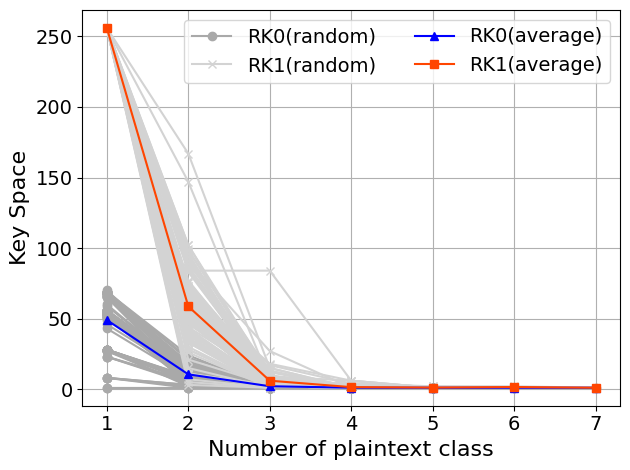

In [21]:
for i, row in enumerate(guess_space0):
    x_values = range(1, len(row) + 1)
    if(i==1):
        plt.plot(x_values, row, color='darkgray' ,marker='o', label='RK0(random)')
    else:
        plt.plot(x_values, row, color='darkgray' ,marker='o')
for i, row in enumerate(guess_space1):
    x_values = range(1, len(row) + 1)
    if(i==1):
        plt.plot(x_values, row, color='lightgray' ,marker='x', label='RK1(random)')
    else:
        plt.plot(x_values, row, color='lightgray' ,marker='x')
x = np.arange(1, len(guess_space0_avg)+1)

plt.plot(x,guess_space0_avg ,color='b', marker='^',label='RK0(average)')
plt.plot(x, guess_space1_avg,color='orangered',marker='s',label='RK1(average)')
plt.grid(True) 

plt.xlabel('Number of plaintext class', fontsize=16)
plt.ylabel('Key Space', fontsize=16)
plt.tick_params(labelsize=14)

plt.legend(fontsize=14, loc='upper right', ncol=2)  
plt.tight_layout()
plt.show()